In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading Data
birth_df = pd.read_csv('C:\\Users\\Asus\\Desktop\\FemaleBirthdate-main\\femaleBithdates.csv')

# Transforming Date column into datetime format
birth_df['Date'] = pd.to_datetime(birth_df['Date'])

#### **Data Wrangling and Augmentation**

In [3]:
# Checking Data information and NaN values
print('Data information')
print(birth_df.describe())
print()
print('Rows vs Columns', birth_df.shape)
print()
print('Nan Values for each column')
print(birth_df.isna().sum())

Data information
           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000

Rows vs Columns (365, 2)

Nan Values for each column
Date      0
Births    0
dtype: int64


In [4]:
# Data Augmentation, Creating Columns to get more data
birth_df['Month'] = birth_df.Date.dt.month
birth_df['Day'] = birth_df.Date.dt.day

In [5]:
# Creating Dataframes grouping by columns
births_by_date = birth_df.groupby(by='Date').sum()
births_by_month = birth_df.groupby(by='Month').sum()
births_by_day = birth_df.groupby(by='Day').sum()

In [6]:
# Dropping Some Columns
births_by_date = births_by_date.drop(columns=['Month', 'Day'])
births_by_month = births_by_month.drop(columns=['Day'])
births_by_day = births_by_day.drop(columns=['Month'])

#### **EDA**

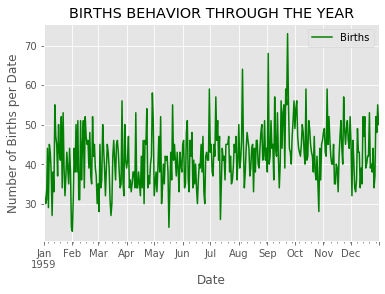

In [7]:
# Plot Tendency for each day of the year
births_by_date.plot(color='g')
plt.title('BIRTHS BEHAVIOR THROUGH THE YEAR')
plt.ylabel('Number of Births per Date')
plt.show()

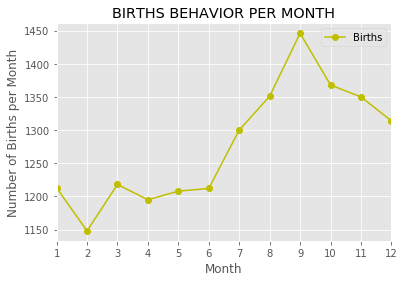

In [8]:
# Plot Tendency for each Month
births_by_month.plot(color='y',marker='o')
plt.title('BIRTHS BEHAVIOR PER MONTH')
plt.ylabel('Number of Births per Month')
plt.xticks(births_by_month.index)
plt.show()

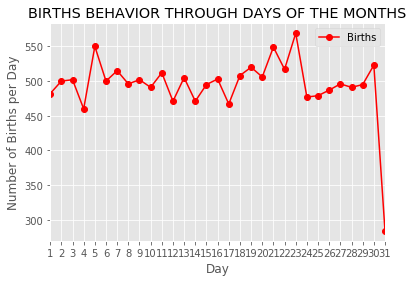

In [9]:
# Plot Tendency for each day of the minth
births_by_day.plot(color='r',linestyle='-',marker='o')
plt.title('BIRTHS BEHAVIOR THROUGH DAYS OF THE MONTHS')
plt.ylabel('Number of Births per Day')
plt.xticks(births_by_day.index)
plt.show()

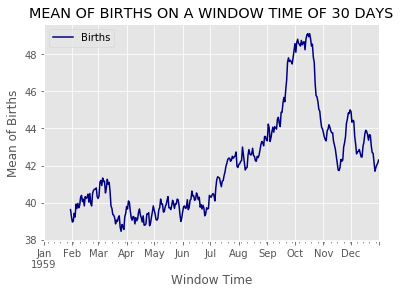

In [10]:
# Lets give a window of 30 days for the year
# Window time
birth_window = birth_df
birth_window = birth_window.drop(columns=['Month','Day'])
birth_df_mean = birth_window
birth_df_mean.set_index('Date', inplace=True)
birth_df_mean = birth_df_mean.rolling( window= 30).mean()
birth_df_mean.plot(color='navy')
plt.title('MEAN OF BIRTHS ON A WINDOW TIME OF 30 DAYS')
plt.xlabel('Window Time')
plt.ylabel('Mean of Births')
plt.show()

#### **Time Series Analysis**

Dickey–Fuller test: p=0.000052


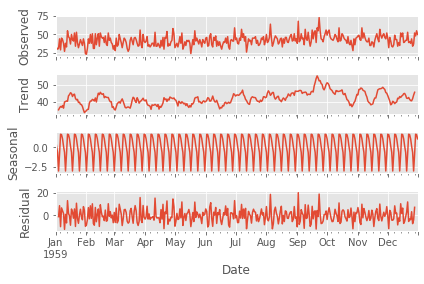

<Figure size 1440x1440 with 0 Axes>

In [11]:
sm.tsa.seasonal_decompose(birth_window.Births).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(birth_window.Births)[1])
plt.figure(figsize=(20,20))
plt.show()

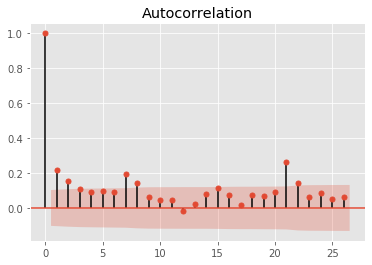

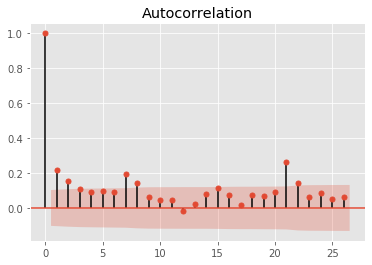

In [12]:
plot_acf(birth_window)

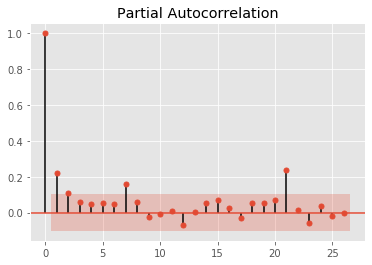

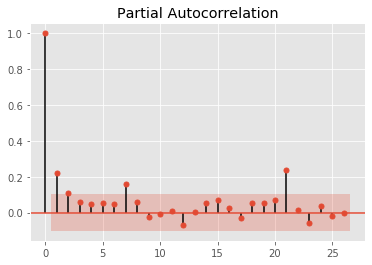

In [13]:
plot_pacf(birth_window)

In [14]:
# Creating variables with the values and the index (date and number of births)
x , y = birth_window.index , birth_df['Births']

In [15]:
model2 = ARIMA(y, order=(0,1,2))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

residuals = pd.DataFrame(model2_fit.resid)

model2_sse = sum((residuals**2).values)
model2_aic = model2_fit.aic

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                  364
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1226.361
Method:                       css-mle   S.D. of innovations              7.006
Date:                Thu, 18 Feb 2021   AIC                           2460.722
Time:                        13:55:29   BIC                           2476.311
Sample:                             1   HQIC                          2466.918
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0150      0.015      1.001      0.317      -0.014       0.044
ma.L1.D.Births    -0.8511      0.050    -17.144      0.000      -0.948      -0.754
ma.L2.D.Births    -0.1113      0.050

In [16]:
df_comp = birth_window.copy()
df_comp = df_comp.asfreq('d')
df_comp.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [17]:
q = [1,2]
p = [1,7]
d = [0,1]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (1, 0, 2) x (1, 0, 2, 12)
SARIMAX: (1, 0, 2) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 2, 12)
SARIMAX: (1, 1, 1) x (7, 0, 1, 12)


In [18]:
rest_dict = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(diff(y),order=param,seasonal_order=param_seasonal)
            results = mod.fit(maxiter=5, method='powell')
#             print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic)) 
            rest_dict[param] = {param_seasonal: results.aic}
        except: 
            continue
print(rest_dict)

Optimization terminated successfully.
         Current function value: 3.363076
         Iterations: 3
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 3.363068
         Iterations: 3
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: 3.314999
         Iterations: 4
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: 3.318707
         Iterations: 4
         Function evaluations: 282
Optimization terminated successfully.
         Current function value: 3.360507
         Iterations: 3
         Function evaluations: 373
Optimization terminated successfully.
         Current function value: 3.360528
         Iterations: 3
         Function evaluations: 403
Optimization terminated successfully.
         Current function value: 3.330291
         Iterations: 4
         Function evaluations: 512
Optimization terminated successful

In [19]:
mod =  SARIMAX(diff(y),
               order=(1, 0, 1),
               seasonal_order=(7, 1, 2, 12))

results = mod.fit(maxiter=100, method='powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 3.330387
         Iterations: 4
         Function evaluations: 547
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1169      0.063      1.843      0.065      -0.007       0.241
ma.L1         -0.9508      0.022    -43.478      0.000      -0.994      -0.908
ar.S.L12      -1.0473      1.104     -0.949      0.343      -3.211       1.117
ar.S.L24      -0.9121      0.698     -1.307      0.191      -2.280       0.456
ar.S.L36      -0.7330      0.587     -1.249      0.212      -1.883       0.417
ar.S.L48      -0.6038      0.450     -1.341      0.180      -1.486       0.279
ar.S.L60      -0.4057      0.368     -1.103      0.270      -1.127       0.315
ar.S.L72      -0.2612      0.216     -1.208      0.227      -0.685       0.163
ar.S.L84      -0.1117      0.113     -0.991      0.322      -0.333      

In [20]:
results

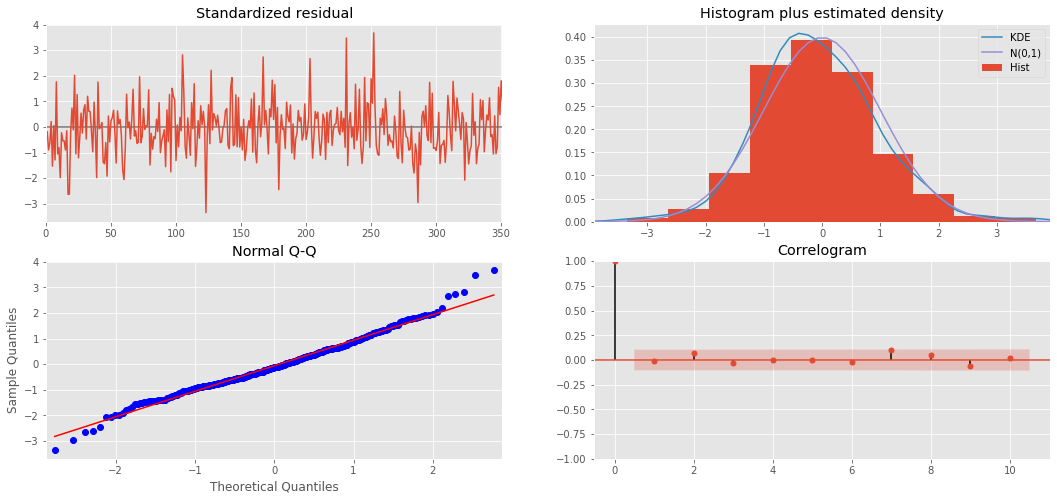

In [21]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()